# Data Imputation dataset generation

In [1]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

c:\Users\rodri\UCA\uca_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("petermayich/car-crashes-california-2006-2021")

In [3]:
df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))

C:\Users\rodri\AppData\Local\Temp\ipykernel_428\450571620.py:1: DtypeWarning: Columns (11,16,25,31,35,37,61,62,63,69,83,84,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, os.listdir(path)[0]))


In [4]:
df.shape

(2678137, 132)

In [5]:
# Calculate percentage of missing values for each column, drop columns with more than 30% missing values
missing_percentage = {col: (df[col].isna().sum() / len(df)) * 100 for col in df.columns}

for col, pct in missing_percentage.items():
    if pct > 30:
        df.drop(columns=[col], inplace=True)

In [6]:
df['timezone'].value_counts()

timezone
America/Los_Angeles    2671874
Etc/GMT+8                 5569
America/Tijuana            508
America/Phoenix            184
1014.4                       1
1016.8                       1
Name: count, dtype: int64

In [7]:
df['tz_offset'].value_counts()

tz_offset
-7.0    1723968
-8.0     954167
 9.9          2
Name: count, dtype: int64

In [8]:
df[df['timezone']=='America/Los_Angeles']['tz_offset'].value_counts()

tz_offset
-7.0    1723480
-8.0     948394
Name: count, dtype: int64

In [9]:
df = df[(df['timezone']=='America/Los_Angeles')]
df.shape

(2671874, 102)

In [10]:
df.drop(columns=['timezone'], inplace=True)

In [11]:
# Check for time span and consecutive days in the dataset

# Get the minimum and maximum dates in the dataset
min_date = pd.to_datetime(df['crash_date'].min())
max_date = pd.to_datetime(df['crash_date'].max())

# Calculate the time span in days
time_span_days = (max_date - min_date).days

print(f"Minimum date in dataset: {min_date.strftime('%Y-%m-%d')}")
print(f"Maximum date in dataset: {max_date.strftime('%Y-%m-%d')}")
print(f"Total time span: {time_span_days} days")

# Find the maximum consecutive days of data
# First, get all unique dates in the dataset
unique_dates = pd.to_datetime(df['crash_date']).dt.date.unique()
unique_dates.sort()

# Convert to datetime for easier manipulation
unique_dates = pd.to_datetime(unique_dates)

# Calculate the difference between consecutive dates
date_diffs = pd.Series(unique_dates).diff().dt.days

# Find where gaps exist (difference > 1 day)
gaps = np.where(date_diffs > 1)[0]

# If no gaps, the entire dataset is consecutive
if len(gaps) == 0:
    max_consecutive_days = len(unique_dates)
    start_idx = 0
    end_idx = len(unique_dates) - 1
else:
    # Add start and end indices to the gaps list for easier processing
    gap_indices = [0] + list(gaps) + [len(unique_dates)]
    
    # Calculate lengths of consecutive day sequences
    consecutive_lengths = [gap_indices[i+1] - gap_indices[i] for i in range(len(gap_indices)-1)]
    
    # Find the maximum consecutive sequence
    max_consecutive_days = max(consecutive_lengths)
    max_idx = consecutive_lengths.index(max_consecutive_days)
    
    # Get the start and end indices of the maximum consecutive sequence
    start_idx = gap_indices[max_idx]
    end_idx = gap_indices[max_idx+1] - 1

# Print the results
print(f"\nMaximum consecutive days: {max_consecutive_days}")
print(f"Start date of longest consecutive sequence: {unique_dates[start_idx].strftime('%Y-%m-%d')}")
print(f"End date of longest consecutive sequence: {unique_dates[end_idx].strftime('%Y-%m-%d')}")

Minimum date in dataset: 2006-06-01
Maximum date in dataset: 2021-06-02
Total time span: 5480 days

Maximum consecutive days: 5392
Start date of longest consecutive sequence: 2006-08-29
End date of longest consecutive sequence: 2021-06-02


In [12]:
# Print the shape of the original and filtered dataframes
print(f"Original dataframe shape: {df.shape}")

# Convert crash_timestamp to datetime if it's not already
df['crash_timestamp'] = pd.to_datetime(df['crash_timestamp'])

# Filter the dataframe for crash_timestamp after than January 1, 2007
df = df[df['crash_timestamp'] >= pd.Timestamp('2007-01-01')]

# Filter the dataframe for crash_timestamp earlier than January 1, 2009
df = df[df['crash_timestamp'] < pd.Timestamp('2009-01-01')]

print(f"Filtered dataframe shape: {df.shape}")

# Display the date range of the filtered dataframe
print(f"\nFiltered dataframe date range: {df['crash_timestamp'].min()} to {df['crash_timestamp'].max()}")

Original dataframe shape: (2671874, 101)
Filtered dataframe shape: (67412, 101)

Filtered dataframe date range: 2007-01-01 02:05:00 to 2008-12-31 23:56:00


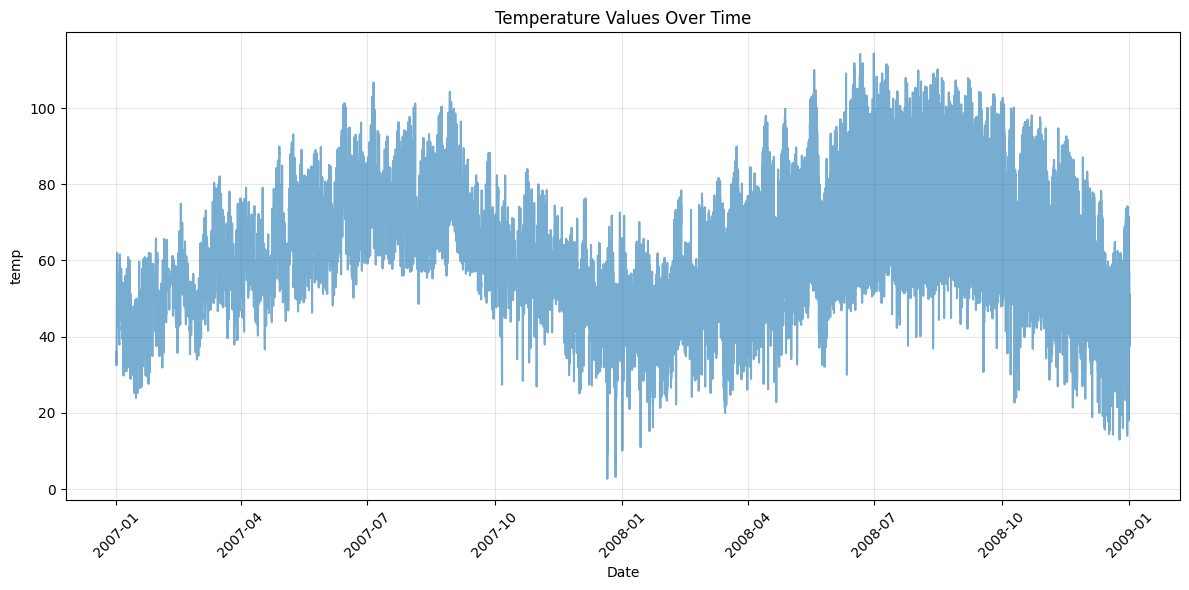

In [13]:
# Sort data by process_date to see the trend over time
sorted_data = df[['crash_timestamp', 'jurisdiction', 'county_location', 'temp']].drop_duplicates().sort_values('crash_timestamp')
plt.figure(figsize=(12, 6))
plt.plot(sorted_data['crash_timestamp'], sorted_data['temp'], '-', alpha=0.6)
plt.title('Temperature Values Over Time')
plt.xlabel('Date')
plt.ylabel('temp')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
sorted_data['jurisdiction'].value_counts().index[0]

np.float64(9252.0)

In [15]:
sorted_data['county_location'].value_counts().index[0]

'los angeles'

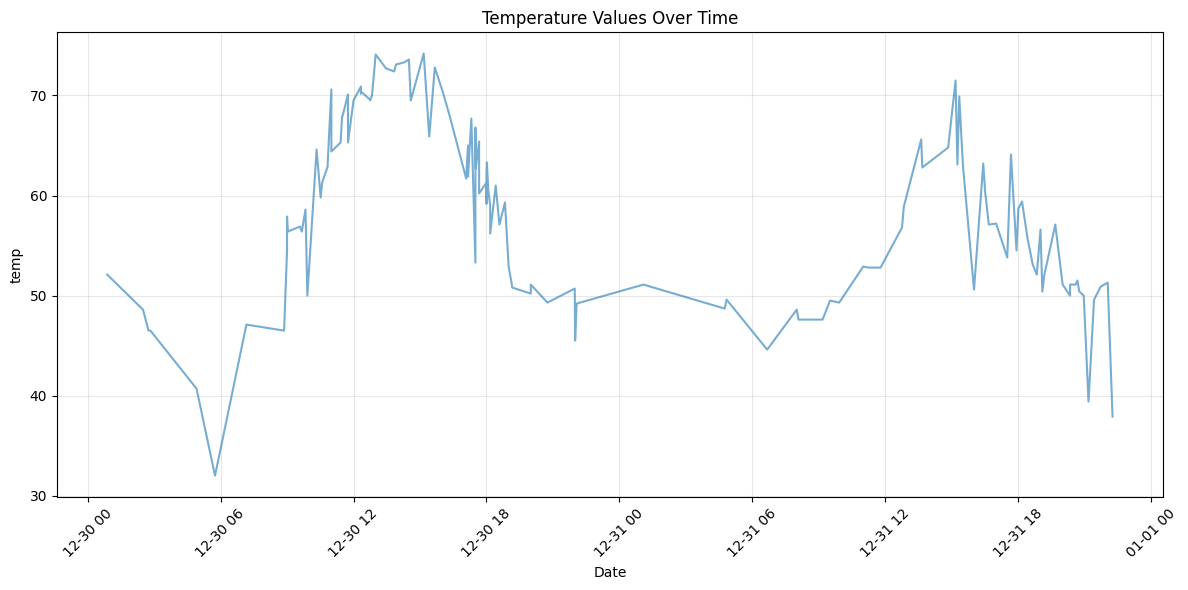

In [16]:
# Extract month and day from crash_timestamp to compare same day across different years
sorted_data['date'] = df['crash_timestamp'].dt.strftime('%Y-%m-%d')
sorted_data['month_year'] = sorted_data['crash_timestamp'].dt.strftime('%m-%Y')

sorted_data2 = sorted_data[sorted_data['county_location'] == sorted_data['county_location'].value_counts().index[0]]

date = '2008-12-29'
plt.figure(figsize=(12, 6))
plt.plot(sorted_data2[sorted_data2['date'] > date]['crash_timestamp'], sorted_data2[sorted_data2['date'] > date]['temp'], '-', alpha=0.6)
plt.title('Temperature Values Over Time')
plt.xlabel('Date')
plt.ylabel('temp')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Create a list of columns that start with 'days_'
days_columns = [col for col in df.columns if col.startswith('days_')]

# Print the list of days columns
print("Columns that start with 'days_':")
print(days_columns)

# Print the count of days columns
print(f"\nTotal number of days columns: {len(days_columns)}")

Columns that start with 'days_':
['days_datetime', 'days_tempmax', 'days_tempmin', 'days_temp', 'days_feelslikemax', 'days_feelslikemin', 'days_feelslike', 'days_dew', 'days_humidity', 'days_precip', 'days_precipprob', 'days_precipcover', 'days_windspeed', 'days_winddir', 'days_pressure', 'days_cloudcover', 'days_visibility', 'days_conditions', 'days_sunrise', 'days_sunset', 'days_moonphase']

Total number of days columns: 21


In [18]:
no_days_columns = []
for col in days_columns:
    if col != 'days_temp':
        no_days_columns.append(col.replace('days_', ''))
        
        # Print the list of days columns
print("Columns that don't start with 'days_':")
print(no_days_columns)

# Print the count of days columns
print(f"\nTotal number of not days columns: {len(no_days_columns)}")

Columns that don't start with 'days_':
['datetime', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'conditions', 'sunrise', 'sunset', 'moonphase']

Total number of not days columns: 20


In [19]:
for col in days_columns:
    df.drop(columns=[col], inplace=True)

for col in no_days_columns:
    try:
        df.drop(columns=[col], inplace=True)
    except:
        pass

In [20]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [21]:
# Display the first 5 rows of the dataframe with all columns
df.head()

,case_id,jurisdiction,officer_id,chp_shift,population,county_city_location,county_location,special_condition,beat_type,chp_beat_type,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_category,pcf_violation,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,process_date,ls_id,crash_time,crash_date,crash_timestamp,lat,long,tz_offset,temp,snow,snowdepth,source,sunrise_epoch,sunset_epoch
10,3041135,9252.0,14512,1400 thru 2159,50000 to 100000,3401,sacramento,0,chp county roadarea,county road area,chp other,060,PRAIRIE CITY RD,RT 50,10.0,south,0.0,cloudy,1.0,1.0,property damage only,0.0,0.0,1,vehicle code violation,improper turning,22107.0,not hit and run,hit object,fixed object,no pedestrian involved,wet,normal,daylight,functioning,1.0,0.0,0.0,0.0,0.0,1.0,passenger car,sport utility vehicle,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2007-06-08 00:00:00,97671192,15:15:00,2007-02-09,2007-02-09 15:15:00,38.64246,-121.15646,-8.0,55.3,0.0,0.0,obs,1.171033e+09,1.171071e+09
11,3048169,9252.0,14512,1400 thru 2159,>250000,3404,sacramento,0,chp state highway,us highway,chp other,151,RT 50,WATT AV,200.0,east,0.0,cloudy,1.0,1.0,property damage only,0.0,0.0,1,vehicle code violation,speeding,22350.0,not hit and run,hit object,fixed object,no pedestrian involved,wet,normal,dark with street lights,none,1.0,0.0,0.0,0.0,0.0,1.0,pickup or panel truck,pickups & panels,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2007-06-11 00:00:00,928403074,19:30:00,2007-02-07,2007-02-07 19:30:00,38.55820,-121.37766,-8.0,53.9,0.0,0.0,obs,1.170947e+09,1.170985e+09
12,3049096,9252.0,9137,0600 thru 1359,unincorporated,3400,sacramento,0,chp county roadline,county road line,chp other,073,STOCKTON BL,MASSIE CT,150.0,south,0.0,cloudy,0.0,0.0,pain,0.0,2.0,2,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0.0,0.0,0.0,0.0,0.0,1.0,pickup or panel truck,pickups & panels,0.0,0,2,0,0,0.0,0.0,0.0,0.0,2007-06-08 00:00:00,112468294,12:30:00,2007-02-20,2007-02-20 12:30:00,38.47859,-121.42077,-8.0,57.0,0.0,0.0,obs,1.171983e+09,1.172023e+09
13,3063469,9252.0,14633,1400 thru 2159,unincorporated,3400,sacramento,0,chp state highway,us highway,chp other,152,RT 50,MANLOVE RD,500.0,east,0.0,clear,1.0,1.0,property damage only,0.0,0.0,2,vehicle code violation,speeding,22350.0,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,dusk or dawn,none,1.0,0.0,0.0,0.0,0.0,1.0,passenger car,"passenger car, station",0.0,0,0,0,0,0.0,0.0,0.0,0.0,2007-07-16 00:00:00,253361866,17:25:00,2007-03-02,2007-03-02 17:25:00,38.55980,-121.37164,-8.0,61.1,0.0,0.0,obs,1.172846e+09,1.172887e+09
14,3090008,9252.0,14611,1400 thru 2159,unincorporated,3400,sacramento,0,chp county roadline,county road line,chp other,073,LAKEWOOD RD,PACIFIC HILLS WY,50.0,north,0.0,clear,0.0,0.0,property damage only,0.0,0.0,2,vehicle code violation,unsafe starting or backing,22106.0,misdemeanor,other,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0.0,0.0,0.0,0.0,0.0,1.0,passenger car,"passenger car, station",0.0,0,0,0,0,0.0,0.0,0.0,0.0,2007-08-15 00:00:00,369561234,16:40:00,2007-03-11,2007-03-11 16:40:00,38.47785,-121.38104,-7.0,75.4,0.0,0.0,obs,1.173623e+09,1.173665e+09


In [22]:
(df['killed_victims'] == (df['pedestrian_killed_count'].astype(int)+df['bicyclist_killed_count'].astype(int)+df['motorcyclist_killed_count'].astype(int))).value_counts()

True     66837
False      575
Name: count, dtype: int64

In [23]:
(df['injured_victims'] == (df['pedestrian_injured_count'].astype(int)+df['bicyclist_injured_count'].astype(int)+df['motorcyclist_injured_count'].astype(int))).value_counts()

True     47073
False    20339
Name: count, dtype: int64

In [24]:
drop_cols = ['case_id', 'jurisdiction', 'county_city_location', 'beat_type', 'chp_beat_type', 'chp_beat_class', 'beat_number', 'distance', 'direction', 'pcf_violation',
             'ls_id', 'crash_time', 'crash_date', 'snow', 'snowdepth', 'source', 'sunrise_epoch', 'sunset_epoch', 'pedestrian_collision', 'pedestrian_killed_count',
             'bicyclist_killed_count', 'motorcyclist_killed_count', 'injured_victims', 'severe_injury_count', 'other_visible_injury_count', 'chp_vehicle_type_at_fault',
             'complaint_of_pain_injury_count', 'pedestrian_injured_count', 'bicyclist_injured_count', 'motorcyclist_injured_count', 'chp_road_type']
df.drop(columns=drop_cols, inplace=True)

df['statewide_vehicle_type_at_fault'].fillna('unknown', inplace=True)

C:\Users\rodri\AppData\Local\Temp\ipykernel_428\779545725.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['statewide_vehicle_type_at_fault'].fillna('unknown', inplace=True)


In [25]:
df.shape

(67412, 35)

In [26]:
df.head()

,officer_id,chp_shift,population,county_location,special_condition,primary_road,secondary_road,intersection,weather_1,state_highway_indicator,tow_away,collision_severity,killed_victims,party_count,primary_collision_factor,pcf_violation_category,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,lighting,control_device,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,statewide_vehicle_type_at_fault,process_date,crash_timestamp,lat,long,tz_offset,temp
10,14512,1400 thru 2159,50000 to 100000,sacramento,0,PRAIRIE CITY RD,RT 50,0.0,cloudy,1.0,1.0,property damage only,0.0,1,vehicle code violation,improper turning,not hit and run,hit object,fixed object,no pedestrian involved,wet,normal,daylight,functioning,0.0,0.0,0.0,1.0,passenger car,2007-06-08 00:00:00,2007-02-09 15:15:00,38.64246,-121.15646,-8.0,55.3
11,14512,1400 thru 2159,>250000,sacramento,0,RT 50,WATT AV,0.0,cloudy,1.0,1.0,property damage only,0.0,1,vehicle code violation,speeding,not hit and run,hit object,fixed object,no pedestrian involved,wet,normal,dark with street lights,none,0.0,0.0,0.0,1.0,pickup or panel truck,2007-06-11 00:00:00,2007-02-07 19:30:00,38.55820,-121.37766,-8.0,53.9
12,9137,0600 thru 1359,unincorporated,sacramento,0,STOCKTON BL,MASSIE CT,0.0,cloudy,0.0,0.0,pain,0.0,2,vehicle code violation,speeding,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0.0,0.0,0.0,1.0,pickup or panel truck,2007-06-08 00:00:00,2007-02-20 12:30:00,38.47859,-121.42077,-8.0,57.0
13,14633,1400 thru 2159,unincorporated,sacramento,0,RT 50,MANLOVE RD,0.0,clear,1.0,1.0,property damage only,0.0,2,vehicle code violation,speeding,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,dusk or dawn,none,0.0,0.0,0.0,1.0,passenger car,2007-07-16 00:00:00,2007-03-02 17:25:00,38.55980,-121.37164,-8.0,61.1
14,14611,1400 thru 2159,unincorporated,sacramento,0,LAKEWOOD RD,PACIFIC HILLS WY,0.0,clear,0.0,0.0,property damage only,0.0,2,vehicle code violation,unsafe starting or backing,misdemeanor,other,other motor vehicle,no pedestrian involved,dry,normal,daylight,none,0.0,0.0,0.0,1.0,passenger car,2007-08-15 00:00:00,2007-03-11 16:40:00,38.47785,-121.38104,-7.0,75.4


In [27]:
(df.isna().sum().sort_values(ascending=False) / len(df)).round(2)

road_surface                       0.01
road_condition_1                   0.01
lighting                           0.01
officer_id                         0.00
weather_1                          0.00
tow_away                           0.00
pcf_violation_category             0.00
type_of_collision                  0.00
control_device                     0.00
temp                               0.00
intersection                       0.00
motor_vehicle_involved_with        0.00
primary_collision_factor           0.00
population                         0.00
pedestrian_action                  0.00
state_highway_indicator            0.00
chp_shift                          0.00
county_location                    0.00
special_condition                  0.00
hit_and_run                        0.00
collision_severity                 0.00
killed_victims                     0.00
party_count                        0.00
secondary_road                     0.00
primary_road                       0.00


In [28]:
df.isna().sum().sort_values(ascending=False)

road_surface                       638
road_condition_1                   502
lighting                           384
officer_id                         313
weather_1                          298
tow_away                           277
pcf_violation_category             238
type_of_collision                  237
control_device                     137
temp                               137
intersection                       121
motor_vehicle_involved_with        103
primary_collision_factor            83
population                          15
pedestrian_action                    6
state_highway_indicator              2
chp_shift                            0
county_location                      0
special_condition                    0
hit_and_run                          0
collision_severity                   0
killed_victims                       0
party_count                          0
secondary_road                       0
primary_road                         0
motorcycle_collision     

In [29]:
df.dropna(inplace=True)
df.shape

(64809, 35)

In [30]:
df.columns

Index(['officer_id', 'chp_shift', 'population', 'county_location',
       'special_condition', 'primary_road', 'secondary_road', 'intersection',
       'weather_1', 'state_highway_indicator', 'tow_away',
       'collision_severity', 'killed_victims', 'party_count',
       'primary_collision_factor', 'pcf_violation_category', 'hit_and_run',
       'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action',
       'road_surface', 'road_condition_1', 'lighting', 'control_device',
       'bicycle_collision', 'motorcycle_collision', 'truck_collision',
       'not_private_property', 'statewide_vehicle_type_at_fault',
       'process_date', 'crash_timestamp', 'lat', 'long', 'tz_offset', 'temp'],
      dtype='object')

In [31]:
# Crear un diccionario para documentar cada columna en el conjunto de datos
columns_description = {
    'officer_id': 'Número de identificación del oficial que reportó el accidente',
    'chp_shift': 'Turno durante el cual se reportó el accidente a la Patrulla de Caminos de California (CHP), si aplica',
    'population': 'Clasificación de población del área donde ocurrió el accidente, frecuentemente usado para análisis estadístico',
    'county_location': 'Nombre del condado donde ocurrió el accidente',
    'special_condition': 'Cualquier condición especial en el sitio del accidente (ej. zona escolar, construcción)',
    'primary_road': 'Carretera principal donde ocurrió el accidente',
    'secondary_road': 'Carretera secundaria involucrada en el accidente, si la hay',
    'intersection': 'Indicador si el accidente ocurrió en o cerca de una intersección',
    'weather_1': 'Condición climática principal al momento del accidente',
    'state_highway_indicator': 'Indica si el accidente ocurrió en una carretera estatal',
    'tow_away': 'Indica si algún vehículo fue remolcado desde la escena del accidente',
    'collision_severity': 'Gravedad de la colisión (ej. fatal, con lesiones, solo daños materiales)',
    'killed_victims': 'Número de víctimas mortales en el accidente',
    'party_count': 'Número de partes involucradas en el accidente',
    'primary_collision_factor': 'Factor principal que contribuyó a la colisión (ej. error humano, falla mecánica)',
    'pcf_violation_category': 'Categoría de la violación del factor principal de colisión',
    'hit_and_run': 'Indica si el accidente fue un atropello con fuga',
    'type_of_collision': 'Tipo de colisión (ej. por detrás, lateral)',
    'motor_vehicle_involved_with': 'Tipo de objeto o vehículo con el que colisionó el vehículo motorizado',
    'pedestrian_action': 'Acción del peatón involucrado en el accidente, si lo hay',
    'road_surface': 'Condición de la superficie de la carretera en el sitio del accidente (ej. mojada, seca)',
    'road_condition_1': 'Condición principal de la carretera en el sitio del accidente (ej. baches, construcción)',
    'lighting': 'Condición de iluminación en el sitio del accidente (ej. luz del día, oscuridad)',
    'control_device': 'Presencia de dispositivos de control de tráfico en el sitio del accidente (ej. señal de alto, semáforo)',
    'bicycle_collision': 'Indica si el accidente involucró a un ciclista',
    'motorcycle_collision': 'Indica si el accidente involucró a una motocicleta',
    'truck_collision': 'Indica si el accidente involucró a un camión',
    'not_private_property': 'Indica si el accidente ocurrió en propiedad pública',
    'statewide_vehicle_type_at_fault': 'Clasificación del tipo de vehículo en falta, usado en análisis estatal',
    'process_date': 'Fecha en que se procesó el informe del accidente',
    'crash_timestamp': 'Marca de tiempo que combina la fecha y hora del accidente',
    'lat': 'Latitud geográfica del sitio del accidente',
    'long': 'Longitud geográfica del sitio del accidente',
    'tz_offset': 'Diferencia de zona horaria desde UTC en la ubicación del accidente',
    'temp': 'Temperatura en el momento y lugar del accidente'
}
len(columns_description)

35

# Descripción de las Columnas del Dataset

- **officer_id**: Número de identificación del oficial que reportó el accidente
- **chp_shift**: Turno durante el cual se reportó el accidente a la Patrulla de Caminos de California (CHP), si aplica
- **population**: Clasificación de población del área donde ocurrió el accidente, frecuentemente usado para análisis estadístico
- **county_location**: Nombre del condado donde ocurrió el accidente
- **special_condition**: Cualquier condición especial en el sitio del accidente (ej. zona escolar, construcción)
- **primary_road**: Carretera principal donde ocurrió el accidente
- **secondary_road**: Carretera secundaria involucrada en el accidente, si la hay
- **intersection**: Indicador si el accidente ocurrió en o cerca de una intersección
- **weather_1**: Condición climática principal al momento del accidente
- **state_highway_indicator**: Indica si el accidente ocurrió en una carretera estatal
- **tow_away**: Indica si algún vehículo fue remolcado desde la escena del accidente
- **collision_severity**: Gravedad de la colisión (ej. fatal, con lesiones, solo daños materiales)
- **killed_victims**: Número de víctimas mortales en el accidente
- **party_count**: Número de partes involucradas en el accidente
- **primary_collision_factor**: Factor principal que contribuyó a la colisión (ej. error humano, falla mecánica)
- **pcf_violation_category**: Categoría de la violación del factor principal de colisión
- **hit_and_run**: Indica si el accidente fue un atropello con fuga
- **type_of_collision**: Tipo de colisión (ej. por detrás, lateral)
- **motor_vehicle_involved_with**: Tipo de objeto o vehículo con el que colisionó el vehículo motorizado
- **pedestrian_action**: Acción del peatón involucrado en el accidente, si lo hay
- **road_surface**: Condición de la superficie de la carretera en el sitio del accidente (ej. mojada, seca)
- **road_condition_1**: Condición principal de la carretera en el sitio del accidente (ej. baches, construcción)
- **lighting**: Condición de iluminación en el sitio del accidente (ej. luz del día, oscuridad)
- **control_device**: Presencia de dispositivos de control de tráfico en el sitio del accidente (ej. señal de alto, semáforo)
- **bicycle_collision**: Indica si el accidente involucró a un ciclista
- **motorcycle_collision**: Indica si el accidente involucró a una motocicleta
- **truck_collision**: Indica si el accidente involucró a un camión
- **not_private_property**: Indica si el accidente ocurrió en propiedad pública
- **statewide_vehicle_type_at_fault**: Clasificación del tipo de vehículo en falta, usado en análisis estatal
- **process_date**: Fecha en que se procesó el informe del accidente
- **crash_timestamp**: Marca de tiempo que combina la fecha y hora del accidente
- **lat**: Latitud geográfica del sitio del accidente
- **long**: Longitud geográfica del sitio del accidente
- **tz_offset**: Diferencia de zona horaria desde UTC en la ubicación del accidente
- **temp**: Temperatura en el momento y lugar del accidente


In [32]:
# Crear una copia del DataFrame para no modificar el original
df_imputation = df.sort_values('crash_timestamp').copy()

# Columnas numéricas para imputación por media/mediana
numeric_cols = ['killed_victims', 'party_count', 'tow_away']
# Introducir valores nulos aleatorios (5% de los datos) en columnas numéricas
for col in numeric_cols:
    mask = np.random.random(len(df_imputation)) < 0.15
    df_imputation.loc[mask, col] = np.nan
print(f"Valores nulos generados en columnas numéricas: {numeric_cols}")

# Columnas categóricas para imputación de variables categóricas
categorical_cols = ['county_location', 'pcf_violation_category', 'primary_collision_factor']
# Introducir valores nulos aleatorios (5% de los datos) en columnas categóricas
for col in categorical_cols:
    mask = np.random.random(len(df_imputation)) < 0.15
    df_imputation.loc[mask, col] = np.nan
print(f"Valores nulos generados en columnas categóricas: {categorical_cols}")

# Columnas temporales/secuenciales para forward/backward fill
sequence_cols = ['process_date']
# Introducir valores nulos aleatorios (5% de los datos) en columnas secuenciales
for col in sequence_cols:
    mask = np.random.random(len(df_imputation)) < 0.15
    df_imputation.loc[mask, col] = np.nan
print(f"Valores nulos generados en columnas secuenciales: {sequence_cols}")

# Columnas espaciales para interpolación
spatial_cols = ['temp']
# Introducir valores nulos en secuencias consecutivas de días
# Seleccionar fechas aleatorias para crear secuencias de valores nulos
num_sequences = int(len(df_imputation['crash_timestamp'].dt.date.unique()) * 0.025)  # Crear aproximadamente 5% de dias

for col in spatial_cols:
    # Reiniciar máscara para cada columna
    mask = np.zeros(len(df_imputation), dtype=bool)
    
    # Obtener fechas únicas ordenadas
    unique_dates = sorted(df_imputation['crash_timestamp'].dt.date.unique())
    
    # Generar secuencias de fechas consecutivas para valores nulos
    for _ in range(num_sequences):
        # Elegir longitud aleatoria de la secuencia de días
        sequence_length = np.random.choice([1, 2, 3, 5, 10])
        
        # Asegurar que podemos seleccionar una secuencia válida
        if len(unique_dates) > sequence_length:
            # Seleccionar un día de inicio aleatorio
            start_idx = np.random.randint(0, len(unique_dates) - sequence_length)
            
            # Obtener la secuencia de fechas consecutivas
            date_sequence = unique_dates[start_idx:start_idx + sequence_length]
            
            # Marcar todos los registros en esas fechas para valores nulos
            for date in date_sequence:
                date_mask = df_imputation['crash_timestamp'].dt.date == date
                mask = mask | date_mask
    
    # Aplicar máscara para crear valores nulos
    df_imputation.loc[mask, col] = np.nan

# Verificar cantidad de valores nulos generados
print("\nCantidad de valores nulos generados en cada columna:")
null_counts = df_imputation.isnull().sum()
print(null_counts[null_counts > 0].sort_values(ascending=False))

Valores nulos generados en columnas numéricas: ['killed_victims', 'party_count', 'tow_away']
Valores nulos generados en columnas categóricas: ['county_location', 'pcf_violation_category', 'primary_collision_factor']
Valores nulos generados en columnas secuenciales: ['process_date']

Cantidad de valores nulos generados en cada columna:
party_count                 9779
primary_collision_factor    9778
killed_victims              9716
pcf_violation_category      9701
county_location             9699
process_date                9660
tow_away                    9562
temp                        5735
dtype: int64


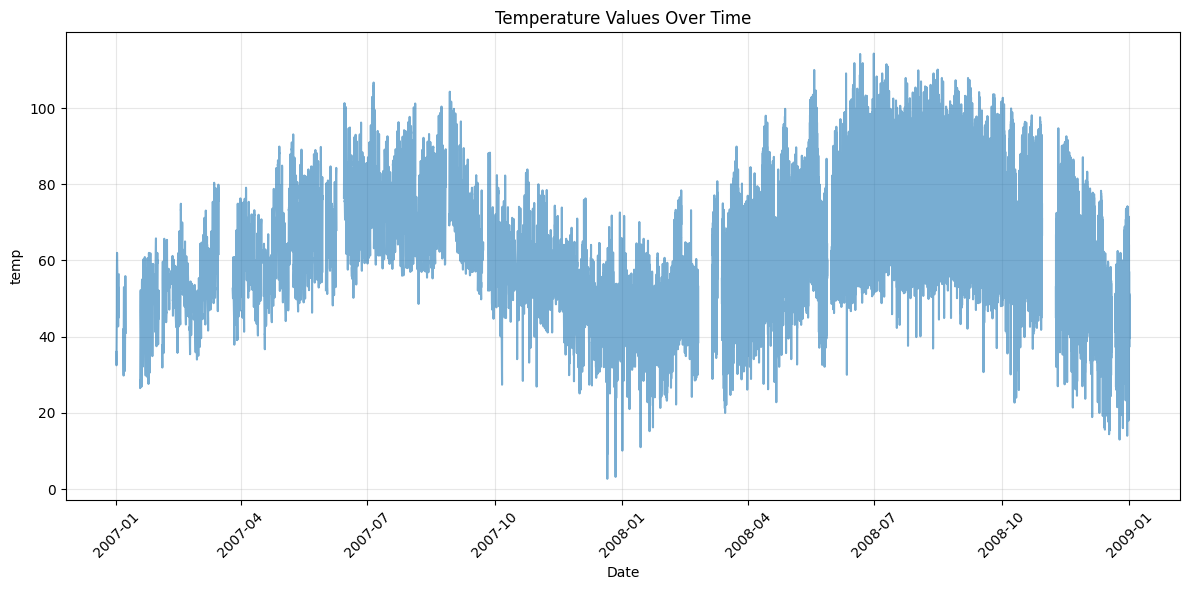

In [33]:
# Sort data by process_date to see the trend over time
sorted_data = df_imputation[['crash_timestamp', 'temp']].drop_duplicates().sort_values('crash_timestamp')
plt.figure(figsize=(12, 6))
plt.plot(sorted_data['crash_timestamp'], sorted_data['temp'], '-', alpha=0.6)
plt.title('Temperature Values Over Time')
plt.xlabel('Date')
plt.ylabel('temp')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Count consecutive NaNs per day in df_imputation
from itertools import groupby
from collections import defaultdict

# Function to count consecutive days with NaN values
def count_consecutive_nan_days(df, column):
    # Group by date and check if any NaN exists for each day
    df['date'] = df['crash_timestamp'].dt.date
    daily_nulls = df.groupby('date')[column].apply(lambda x: x.isna().any())
    
    # Find consecutive sequences of days with NaNs
    is_null_days = daily_nulls[daily_nulls].index.tolist()
    
    if not is_null_days:
        return 0
    
    # Sort dates to ensure proper sequence detection
    is_null_days.sort()
    
    # Initialize tracking
    max_consecutive = 1
    current_consecutive = 1
    
    # Count consecutive days
    for i in range(1, len(is_null_days)):
        # Check if dates are consecutive (1 day difference)
        if (is_null_days[i] - is_null_days[i-1]).days == 1:
            current_consecutive += 1
        else:
            # Reset counter when sequence breaks
            current_consecutive = 1
        
        max_consecutive = max(max_consecutive, current_consecutive)
    
    return max_consecutive

# Calculate consecutive NaN days for each column
consecutive_nan_days = {}
for column in df_imputation.columns:
    if df_imputation[column].isna().any():  # Only check columns with NaNs
        consecutive_nan_days[column] = count_consecutive_nan_days(df_imputation, column)

# Sort and display results
consecutive_nan_days_series = pd.Series(consecutive_nan_days).sort_values(ascending=False)
print("Maximum consecutive days with NaN values in each column:")
print(consecutive_nan_days_series)

# For temp column specifically
if 'temp' in consecutive_nan_days:
    max_temp_nan_days = consecutive_nan_days['temp']
    print(f"\nMaximum consecutive days with NaN values in temp column: {max_temp_nan_days}")

Maximum consecutive days with NaN values in each column:
county_location             401
tow_away                    396
primary_collision_factor    389
pcf_violation_category      370
killed_victims              353
process_date                346
party_count                 340
temp                         10
dtype: int64

Maximum consecutive days with NaN values in temp column: 10


In [35]:
df_imputation.to_csv('car_crashes_california_2007_2008.csv', index=False)